# Gekko for solving OCT

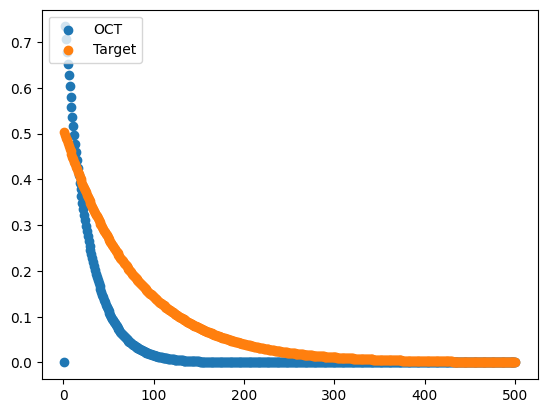

2.6386914533
3.8166826714
0.0
36.543549802


In [ ]:
#One administration case
#PLEASE USE N ADMINSTRATIONS CODE BELOW

from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

#Constants

# WT = wild-type: "normal" version of the allele
V_max_u_wt = 3.5              # pmol/min per pmol cyp
k_m_u_wt = 16                 # umol/L

# mut = allele other than WT 
V_max_u_mut = 8.2              # pmol/min per pmol cyp
k_m_u_mut = 12                 # umol/L

dose_u= 1.4                  # [mg/m^2]
BV_u = 5                   # L
BV = BV_u
BSA_u = 1.8                # m^2
dose_wt = dose_u * BSA_u   # mg
pmol_cyp = 2929510         # pmol cyp
mm_cyp = 57343            # g/mol for cyp
mm_drug = 825              # g/mol for vincristine

t_max = 500             # min
t_step = 1                 # min

#Unit conversions
V_max_wt = V_max_u_wt * pmol_cyp * mm_drug * (10 ** -9)
k_m_wt = k_m_u_wt * (10 ** -2) * mm_drug

V_max_mut = V_max_u_mut* pmol_cyp * mm_drug * (10 ** -9)
k_m_mut = k_m_u_mut * (10 ** -2) * mm_drug

# Initialize the model
m = GEKKO(remote=True)

# Define the number of time steps and time vector
#nt= t_max//t_step
m.time = np.arange(1, t_max+1, t_step).tolist()
num_steps = len(m.time)

# Setting up target curve
C_B_target = m.Var(value=dose_wt/BV, name="C_B_target")  # Blood concentration in mg/L
M_target = m.Var(value=0.0, name = "M_target")  # Total amount of drug metabolized (mg)

m.Equation(C_B_target == (dose_wt - M_target) / BV)  # Rate of change of blood concentration
m.Equation(M_target.dt() == (V_max_wt * C_B_target) / (k_m_wt + C_B_target))  # Michaelis-Menten kinetics

#Setting up personalized curve
dose_init = m.FV(dose_wt,0, name = "dose_init") # Initial Dose Parameter, with default value of SOC
dose_init.STATUS = 1 #allowing initial dose to be modified
C_B_mut = m.Var(value=dose_init/BSA_u, name="C_B_mut")  # Blood concentration in mg/L
M_mut = m.Var(value=0.0, name = "M_mut")  # Total amount of drug metabolized (mg)

m.Equation(C_B_mut == (dose_init - M_mut) / BV)  # Rate of change of blood concentration
m.Equation(M_mut.dt() == (V_max_mut * C_B_mut) / (k_m_mut + C_B_mut))  # Michaelis-Menten kinetics

# Optimization target
conc_cost_inst = m.Var(0, name="j_conc_cost_inst")
m.Equation(conc_cost_inst == (C_B_target - C_B_mut)**2)
conc_cost = m.Var(0, name = "j_conc_cost")
m.Equation(conc_cost.dt() == conc_cost_inst)

w1 = 1
w2 = 1/200
cost_tot = m.Var(name = "j_cost_tot")
m.Equation(cost_tot == w1*conc_cost + w2*dose_init**2)

#amortizing the cost of the total amount of drug administered over the whole time course so that when gekko sums the cost over time it gets the right number
cost_tot_amortized = m.Var(name = "j_cost_tot_amortized")
m.Equation(cost_tot_amortized == w1*conc_cost_inst + w2/num_steps*(dose_init**2))
m.Minimize(cost_tot_amortized)

# Solve the optimization problem
m.options.IMODE = 6 # optimal control mode
m.options.MAX_ITER = 1e6
m.options.DIAGLEVEL = 1
#m.open_folder()
m.options.SOLVER = 1  # APOPT solver+
m.solve(disp=False) # solve

# Plot results
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(m.time,C_B_mut, label = "OCT")
ax1.scatter(m.time,C_B_target, label = "Target")
plt.legend(loc = 'upper left')
plt.show()
print(m.options.OBJFCNVAL)
print(dose_init[1])


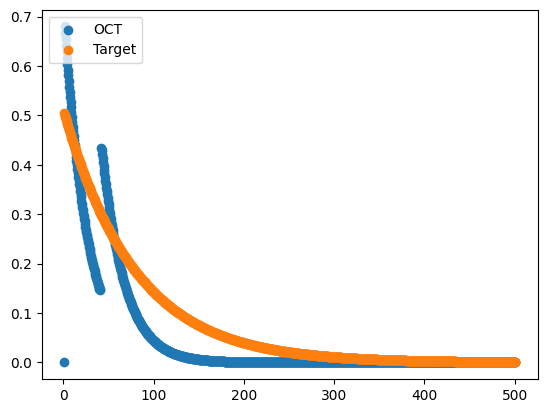

1.5239601306
3.468180737
1.5573218404
40.491534326


In [ ]:
#for 2 adminstrations
#PLEASE USE N ADMINSTRATIONS CODE BELOW

from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt


V_max_u_wt = 3.5              # pmol/min per pmol cyp
k_m_u_wt = 16                 # umol/L

#fast metabolizer
V_max_u_mut = 8.2              # pmol/min per pmol cyp
k_m_u_mut = 12                 # umol/L

#slow metabolizer
#V_max_u_mut = 2              # pmol/min per pmol cyp
#k_m_u_mut = 32                # umol/L

#average metabolizer (same as wild type)
#V_max_u_mut = 3.5              # pmol/min per pmol cyp
#k_m_u_mut = 16                 # umol/L

dose_u= 1.4                  # [mg/m^2]
BV_u = 5                   # L
BV = BV_u
BSA_u = 1.8                # m^2
dose_wt = dose_u * BSA_u   # mg
pmol_cyp = 2929510         # pmol cyp
mm_cyp = 57343            # g/mol for cyp
mm_drug = 825              # g/mol for vincristine

t_max = 500             # min
t_step = 0.5                 # min
n_admin = 2

#unit conversions
V_max_wt = V_max_u_wt * pmol_cyp * mm_drug * (10 ** -9)
k_m_wt = k_m_u_wt * (10 ** -2) * mm_drug

V_max_mut = V_max_u_mut* pmol_cyp * mm_drug * (10 ** -9)
k_m_mut = k_m_u_mut * (10 ** -2) * mm_drug

# Initialize the model
m = GEKKO(remote=True)

# Define the number of time steps and time vector
#nt= t_max//t_step
m.time = np.arange(1, t_max+1, t_step).tolist()
num_steps = len(m.time)
t = m.Var(0)
m.Equation(t.dt()==1)

# Setting up target curve
C_B_target = m.Var(value=dose_wt/BV, name="C_B_target")  # Blood concentration in mg/L
M_target = m.Var(value=0.0, name = "M_target")  # Total amount of drug metabolized (mg)

m.Equation(C_B_target == (dose_wt - M_target) / BV)  # Rate of change of blood concentration
m.Equation(M_target.dt() == (V_max_wt * C_B_target) / (k_m_wt + C_B_target))  # Michaelis-Menten kinetics

# Setting up personalized curve
dose_init = m.FV(3.48,0,6, name = "dose_init") # Initial Dose Parameter, with minimum of zero
dose_init.STATUS = 1

#dose_wt
dose_two = m.FV(1.6,0,6, name = "dose_two") # Second Dose Parameter, with minimum of zero
dose_two.STATUS = 1

#(t_max)//3
time_two = m.FV(40,0,(t_max*9)//10, name = "time_two") # Timing of second Dose Parameter, minimum of zero, max of 90% of sim time
time_two.STATUS = 1

#"step function" for adminstration of second dose, using tanh as switch function b/c gekko doesn't like discontinuity and tanh is close enough
h_2 = m.Var(0,name="h_2")
m.Equation(h_2 == (m.tanh(4*(t-time_two))/2+0.5)*dose_two)
#m.Equation(h_2 == m.if2(t - time_two,0,dose_two))

h_tot = m.Var(dose_init, name="h_tot")
m.Equation(h_tot == dose_init + h_2)

C_B_mut = m.Var(value=dose_init/BSA_u, name="C_B_mut")  # Blood concentration in mg/L
M_mut = m.Var(value=0.0, name = "M_mut")  # Total amount of drug metabolized (mg)

m.Equation(C_B_mut == (h_tot - M_mut) / BV)  # Rate of change of blood concentration
m.Equation(M_mut.dt() == (V_max_mut * C_B_mut) / (k_m_mut + C_B_mut))  # Michaelis-Menten kinetics

# Optimization target

conc_cost_inst = m.Var(0, name="j_conc_cost_inst")
m.Equation(conc_cost_inst == (C_B_target - C_B_mut)**2)
conc_cost = m.Var(0, name = "j_conc_cost")
m.Equation(conc_cost.dt() == conc_cost_inst)

w1 = 1
#w2 = 1/100
w2 = 1/200
cost_tot = m.Var(name = "j_cost_tot")
m.Equation(cost_tot == w1*conc_cost + w2*(dose_init+dose_two)**2)
#m.Minimize(cost_tot)

cost_tot_amortized = m.Var(name = "j_cost_tot_amortized")
m.Equation(cost_tot_amortized == 1*(w1*conc_cost_inst*t_step + w2/num_steps*((dose_init+dose_two)**2)))
m.Obj(cost_tot_amortized)

# Solve the optimization problem
m.options.IMODE = 6 # optimal control mode
m.options.MAX_ITER = 100
m.options.DIAGLEVEL = 1
m.options.MAX_TIME = 300
m.options.REDUCE = 5
#m.open_folder()
m.options.SOLVER = 1  # APOPT solver
m.solve(disp=False, debug = 0) # solve

# Plot results
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(m.time,C_B_mut, label = "OCT")
ax1.scatter(m.time,C_B_target, label = "Target")
plt.legend(loc = 'upper left')
plt.show()
print(m.options.OBJFCNVAL)
print(dose_init[1])
print(dose_two[1])
print(time_two[1])



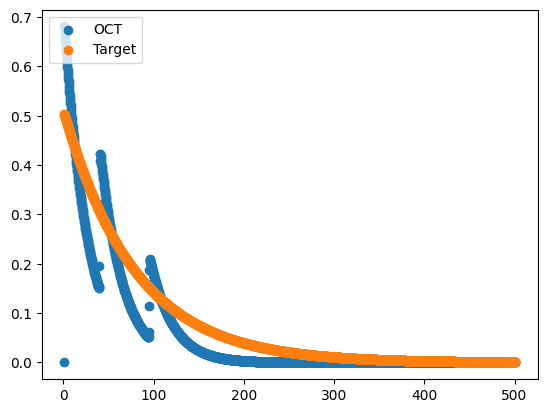

1.1737406612
3.4394745692
1.4609861533
39.192710415
0.83856443443
94.0542674


In [ ]:
#for 3 adminstrations
#PLEASE USE N ADMINSTRATIONS CODE BELOW

from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt


V_max_u_wt = 3.5              # pmol/min per pmol cyp
k_m_u_wt = 16                 # umol/L

#fast metabolizer
V_max_u_mut = 8.2              # pmol/min per pmol cyp
k_m_u_mut = 12                 # umol/L

#slow metabolizer
#V_max_u_mut = 2              # pmol/min per pmol cyp
#k_m_u_mut = 32                # umol/L

#average metabolizer (same as wild type)
#V_max_u_mut = 3.5              # pmol/min per pmol cyp
#k_m_u_mut = 16                 # umol/L

dose_u= 1.4                  # [mg/m^2]
BV_u = 5                   # L
BV = BV_u
BSA_u = 1.8                # m^2
dose_wt = dose_u * BSA_u   # mg
pmol_cyp = 2929510         # pmol cyp
mm_cyp = 57343            # g/mol for cyp
mm_drug = 825              # g/mol for vincristine

t_max = 500             # min
t_step = 0.25                 # min
n_admin = 2

#unit conversions
V_max_wt = V_max_u_wt * pmol_cyp * mm_drug * (10 ** -9)
k_m_wt = k_m_u_wt * (10 ** -2) * mm_drug

V_max_mut = V_max_u_mut* pmol_cyp * mm_drug * (10 ** -9)
k_m_mut = k_m_u_mut * (10 ** -2) * mm_drug

# Initialize the model
m = GEKKO(remote=True)

# Define the number of time steps and time vector
#nt= t_max//t_step
m.time = np.arange(1, t_max+1, t_step).tolist()
num_steps = len(m.time)
t = m.Var(0)
m.Equation(t.dt()==1)

# Setting up target curve
C_B_target = m.Var(value=dose_wt/BV, name="C_B_target")  # Blood concentration in mg/L
M_target = m.Var(value=0.0, name = "M_target")  # Total amount of drug metabolized (mg)

m.Equation(C_B_target == (dose_wt - M_target) / BV)  # Rate of change of blood concentration
m.Equation(M_target.dt() == (V_max_wt * C_B_target) / (k_m_wt + C_B_target))  # Michaelis-Menten kinetics

# Setting up personalized curve
dose_init = m.FV(3.48,0,6, name = "dose_init") # Initial Dose Parameter, with minimum of zero
dose_init.STATUS = 1

dose_two = m.FV(1.6,0,6, name = "dose_two") # Second Dose Parameter, with minimum of zero
dose_two.STATUS = 1

time_two = m.FV(40,0,(t_max*9)//10, name = "time_two") # Timing of second Dose Parameter, minimum of zero, max of 90% of sim time
time_two.STATUS = 1

dose_three = m.FV(1,0,6, name = "dose_three") # third Dose Parameter, with minimum of zero
dose_three.STATUS = 1

time_three = m.FV(100,0,(t_max*9)//10, name = "time_three") # Timing of third Dose Parameter, minimum of zero, max of 90% of sim time
time_three.STATUS = 1

#"step function" for adminstration of second and third doses, using tanh as switch function b/c gekko doesn't like discontinuity and tanh is close enough
h_2 = m.Var(0,name="h_2")
m.Equation(h_2 == (m.tanh(4*(t-time_two))/2+0.5)*dose_two)

h_3 = m.Var(0,name="h_3")
m.Equation(h_3 == (m.tanh(4*(t-time_three))/2+0.5)*dose_three)

h_tot = m.Var(dose_init, name="h_tot")
m.Equation(h_tot == dose_init + h_2 + h_3)

C_B_mut = m.Var(value=dose_init/BSA_u, name="C_B_mut")  # Blood concentration in mg/L
M_mut = m.Var(value=0.0, name = "M_mut")  # Total amount of drug metabolized (mg)

m.Equation(C_B_mut == (h_tot - M_mut) / BV)  # Rate of change of blood concentration
m.Equation(M_mut.dt() == (V_max_mut * C_B_mut) / (k_m_mut + C_B_mut))  # Michaelis-Menten kinetics

# Optimization target

conc_cost_inst = m.Var(0, name="j_conc_cost_inst")
m.Equation(conc_cost_inst == (C_B_target - C_B_mut)**2)
conc_cost = m.Var(0, name = "j_conc_cost")
m.Equation(conc_cost.dt() == conc_cost_inst)

w1 = 1
#w2 = 1/100
w2 = 1/200
cost_tot = m.Var(name = "j_cost_tot")
m.Equation(cost_tot == w1*conc_cost + w2*(dose_init+dose_two+dose_three)**2)
#m.Minimize(cost_tot)

cost_tot_amortized = m.Var(name = "j_cost_tot_amortized")
m.Equation(cost_tot_amortized == 1*(w1*conc_cost_inst*t_step + w2/num_steps*((dose_init+dose_two+dose_three)**2)))
m.Obj(cost_tot_amortized)

# Solve the optimization problem
m.options.IMODE = 6 # optimal control mode
m.options.MAX_ITER = 100
m.options.DIAGLEVEL = 1
m.options.MAX_TIME = 300
m.options.REDUCE = 5
#m.open_folder()
m.options.SOLVER = 1  # APOPT solver
m.solve(disp=False, debug = 0) # solve

# Plot results
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(m.time,C_B_mut, label = "OCT")
ax1.scatter(m.time,C_B_target, label = "Target")
plt.legend(loc = 'upper left')
plt.show()
print(m.options.OBJFCNVAL)
print(dose_init[1])
print(dose_two[1])
print(time_two[1])
print(dose_three[1])
print(time_three[1])



In [ ]:
#n adminstrations (1-5)

from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

################################################################
#INPUTS

n_admin = 4 #(must be 1-5)

V_max_u_wt = 3.5              # pmol/min per pmol cyp
k_m_u_wt = 16                 # umol/L

#example fast metabolizer case
V_max_u_mut = 8.2              # pmol/min per pmol cyp
k_m_u_mut = 12                 # umol/L

#example slow metabolizer case
#V_max_u_mut = 2              # pmol/min per pmol cyp
#k_m_u_mut = 32                # umol/L

#example average metabolizer case (same as wild type)
#V_max_u_mut = 3.5              # pmol/min per pmol cyp
#k_m_u_mut = 16                 # umol/L

dose_u= 1.4                  # [mg/m^2]
BV_u = 5                   # L
BV = BV_u
BSA_u = 1.8                # m^2
dose_wt = dose_u * BSA_u   # mg
pmol_cyp = 2929510         # pmol cyp
mm_cyp = 57343            # g/mol for cyp
mm_drug = 825              # g/mol for vincristine

t_max = 500             # min
t_step = 0.5                 # min

#END INPUTS
######################################################################

#unit conversions
V_max_wt = V_max_u_wt * pmol_cyp * mm_drug * (10 ** -9)
k_m_wt = k_m_u_wt * (10 ** -2) * mm_drug

V_max_mut = V_max_u_mut* pmol_cyp * mm_drug * (10 ** -9)
k_m_mut = k_m_u_mut * (10 ** -2) * mm_drug

# Initialize the model
m = GEKKO(remote=True)

# Define the number of time steps and time vector
#nt= t_max//t_step
m.time = np.arange(1, t_max+1, t_step).tolist()
num_steps = len(m.time)
t = m.Var(0)
m.Equation(t.dt()==1)

# Setting up target curve
C_B_target = m.Var(value=dose_wt/BV, name="C_B_target")  # Blood concentration in mg/L
M_target = m.Var(value=0.0, name = "M_target")  # Total amount of drug metabolized (mg)

m.Equation(C_B_target == (dose_wt - M_target) / BV)  # Rate of change of blood concentration
m.Equation(M_target.dt() == (V_max_wt * C_B_target) / (k_m_wt + C_B_target))  # Michaelis-Menten kinetics

# Setting up personalized curve
#"step function" for adminstration of all but first doses, using tanh as switch function b/c gekko doesn't like discontinuity and tanh is close enough

dose_init = m.FV(3.48,0,6, name = "dose_init") # Initial Dose Parameter, with minimum of zero
dose_init.STATUS = 1

if n_admin >= 2:
    dose_two = m.FV(1.6,0,6, name = "dose_two") # Second Dose Parameter, with minimum of zero
    dose_two.STATUS = 1

    time_two = m.FV(40,0,(t_max*9)//10, name = "time_two") # Timing of second Dose Parameter, minimum of zero, max of 90% of sim time
    time_two.STATUS = 1

    h_2 = m.Var(0,name="h_2")
    m.Equation(h_2 == (m.tanh(4*(t-time_two))/2+0.5)*dose_two)

if n_admin >= 3:
    dose_three = m.FV(1,0,6, name = "dose_three") # third Dose Parameter, with minimum of zero
    dose_three.STATUS = 1

    time_three = m.FV(100,0,(t_max*9)//10, name = "time_three") # Timing of third Dose Parameter, minimum of zero, max of 90% of sim time
    time_three.STATUS = 1

    h_3 = m.Var(0,name="h_3")
    m.Equation(h_3 == (m.tanh(4*(t-time_three))/2+0.5)*dose_three)

if n_admin >= 4:
    dose_four = m.FV(0.3,0,6, name = "dose_four") # third Dose Parameter, with minimum of zero
    dose_four.STATUS = 1

    time_four = m.FV(150,0,(t_max*9)//10, name = "time_four") # Timing of third Dose Parameter, minimum of zero, max of 90% of sim time
    time_four.STATUS = 1

    h_4 = m.Var(0,name="h_4")
    m.Equation(h_4 == (m.tanh(4*(t-time_four))/2+0.5)*dose_four)

if n_admin >= 5:
    dose_five = m.FV(0.1,0,6, name = "dose_five") # third Dose Parameter, with minimum of zero
    dose_five.STATUS = 1

    time_five = m.FV(200,0,(t_max*9)//10, name = "time_five") # Timing of third Dose Parameter, minimum of zero, max of 90% of sim time
    time_five.STATUS = 1

    h_5 = m.Var(0,name="h_5")
    m.Equation(h_5 == (m.tanh(4*(t-time_five))/2+0.5)*dose_five)


h_tot = m.Var(dose_init, name="h_tot")
d_tot = m.Var(dose_init, name="d_tot")

if n_admin == 1:
    m.Equation(h_tot == dose_init)
    m.Equation(d_tot == dose_init)
elif n_admin == 2:
    m.Equation(h_tot == dose_init + h_2)
    m.Equation(d_tot == dose_init + dose_two)
elif n_admin == 3:
    m.Equation(h_tot == dose_init + h_2 + h_3)
    m.Equation(d_tot == dose_init + dose_two + dose_three)
elif n_admin == 4:
    m.Equation(h_tot == dose_init + h_2 + h_3 + h_4)
    m.Equation(d_tot == dose_init + dose_two + dose_three + dose_four)
elif n_admin == 5:
    m.Equation(h_tot == dose_init + h_2 + h_3 + h_4 + h_5)
    m.Equation(d_tot == dose_init + dose_two + dose_three + dose_four + dose_five)

C_B_mut = m.Var(value=dose_init/BSA_u, name="C_B_mut")  # Blood concentration in mg/L
M_mut = m.Var(value=0.0, name = "M_mut")  # Total amount of drug metabolized (mg)

m.Equation(C_B_mut == (h_tot - M_mut) / BV)  # Rate of change of blood concentration
m.Equation(M_mut.dt() == (V_max_mut * C_B_mut) / (k_m_mut + C_B_mut))  # Michaelis-Menten kinetics

# Optimization target

conc_cost_inst = m.Var(0, name="j_conc_cost_inst")
m.Equation(conc_cost_inst == (C_B_target - C_B_mut)**2)
conc_cost = m.Var(0, name = "j_conc_cost")
m.Equation(conc_cost.dt() == conc_cost_inst)

w1 = 1
#w2 = 1/100
w2 = 1/200
cost_tot = m.Var(name = "j_cost_tot")
m.Equation(cost_tot == w1*conc_cost + w2*(d_tot)**2)
#m.Minimize(cost_tot)

cost_tot_amortized = m.Var(name = "j_cost_tot_amortized")
m.Equation(cost_tot_amortized == 1*(w1*conc_cost_inst*t_step + w2/num_steps*((d_tot)**2)))
m.Obj(cost_tot_amortized)

# Solve the optimization problem
m.options.IMODE = 6 # optimal control mode
m.options.MAX_ITER = 100
m.options.DIAGLEVEL = 1
m.options.MAX_TIME = 300
m.options.REDUCE = 5
#m.open_folder()
m.options.SOLVER = 1  # APOPT solver
m.solve(disp=False, debug = 0) # solve

# Plot results
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(m.time,C_B_mut, label = "OCT")
ax1.scatter(m.time,C_B_target, label = "Target")
plt.legend(loc = 'upper left')
plt.show()
print("Cost:" + m.options.OBJFCNVAL)
print("Initial Dose Amount (mg): " , dose_init[1])
if n_admin >=2:
    print("Second Dose Amount (mg): " , dose_two[1])
    print("Time of Second Dose (min)" , time_two[1])
if n_admin >=3:
    print("Third Dose Amount (mg): " , dose_three[1])
    print("Time of Third Dose (min)" , time_three[1])
if n_admin >=4:
    print("Fourth Dose Amount (mg): " , dose_four[1])
    print("Time of Fourth Dose (min)" , time_four[1])
if n_admin >=5:
    print("Fifth Dose Amount (mg): " , dose_four[1])
    print("Time of Fifth Dose (min)" , time_four[1])

